# Homework 5: Part I

1. Go get data from kaggle.com and do a ***Bayesian Linear Regression*** analysis

```python
import pymc as pm; import numpy as np
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))
# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()
```    

2. Choose ***prior*** that are sensible: certainly you might change the ***hyperparameters***, and perhaps you can experiment with different distributional families for `sigma`...

3. [Optional] Assess the performance of the MCMC and note any issues or warnings

    1. Traceplots, inference (credible) intervals, effective sample sizes, energy plots, warnings and other notes... just the usual stuff they do [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

4. [Optional] Perform ***Multiple Linear Regression*** diagnostics... residual plots, etc.


In [40]:
# Import necessary modules
import random
import pymc as pm
import arviz as az
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests

I have found this dataset about obesity in Kaggle, and here is the link to the dataset: https://www.kaggle.com/datasets/mrsimple07/obesity-prediction?resource=download

The dataset consists of 1000 individuals who are categorized as underweight, normal weight, overweight, and obese.

In [39]:
# Set directory to Google Drive to get dataset
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/STA365')
# Read dataset
df = pd.read_csv("obesity_data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Take a quick look at data
df.describe()

,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


We are going to use BMI as a response variable, and age and physical activity level as predictors.

## Question 1

In [42]:
# Use sample code to do a Bayesian Linear Regression
n, p = 1000, 3 # 2 predictors + 1 intercept;
X = np.hstack((np.ones((n, 1)), df[['Age', 'PhysicalActivityLevel']].values))
y = df['BMI'].values
y.shape = (n,1)
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y_obs = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)
with MLR:
  idata = pm.sample()

In [43]:
# Generate summary statistics after model fitting
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",15.73,0.63,14.60,16.99,0.02,0.01,1592.75,1575.96,1.0
"betas[0, 1]",15.73,0.62,14.58,16.91,0.01,0.01,1742.38,1528.46,1.0
"betas[0, 2]",15.75,0.64,14.58,16.95,0.02,0.01,1472.23,1406.03,1.0
"betas[1, 0]",0.09,0.01,0.07,0.11,0.00,0.00,1980.35,1409.58,1.0
"betas[1, 1]",0.09,0.01,0.07,0.11,0.00,0.00,1802.30,1561.71,1.0
"betas[1, 2]",0.09,0.01,0.07,0.11,0.00,0.00,2210.27,1445.74,1.0
"betas[2, 0]",1.61,0.17,1.31,1.94,0.00,0.00,2073.27,1232.65,1.0
"betas[2, 1]",1.61,0.17,1.29,1.90,0.00,0.00,2308.41,1462.91,1.0
"betas[2, 2]",1.60,0.18,1.25,1.91,0.00,0.00,2115.28,1376.75,1.0
sigma,6.66,0.09,6.48,6.83,0.00,0.00,2073.56,1343.63,1.0


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

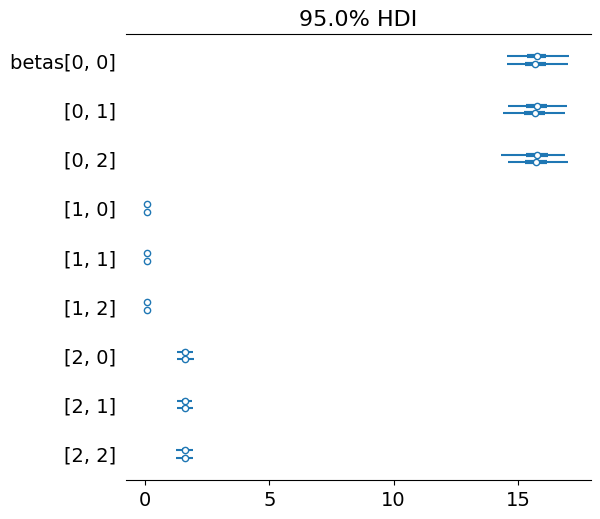

In [44]:
# Sketch credible intervals
plt.subplots_adjust(hspace=0.5)
az.plot_forest(idata, var_names=["betas"], combined=False, hdi_prob=0.95)

## Question 2
Now I will select more sensible priors. I have found very limited information online on the exact number that captures the linear relationship between the variables, but in general BMI has a positive correlation with age and a negative correlation with physical activity levels. Therefore I am going to specify priors with the coefficient for age is normally distributed around +1 and that of physical activity levels is normally distributed around -2. I am also going to raise the variance of prior of sigma drastically to make it weakly informative.

In [61]:
# Use sample code to do a Bayesian Linear Regression
n, p = 1000, 3 # 2 predictors + 1 intercept;
X = np.hstack((np.ones((n, 1)), df[['Age', 'PhysicalActivityLevel']].values))
y = df['BMI'].values
y.shape = (n,1)
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.array([[0], [1], [-2]]),
                        cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=100, lower=0) # half normal
    y_obs = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)
with MLR:
  idata = pm.sample()

In [62]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",15.79,0.64,14.54,16.96,0.02,0.01,1601.18,1600.99,1.0
"betas[0, 1]",15.78,0.68,14.52,17.02,0.02,0.01,1652.99,1419.43,1.0
"betas[0, 2]",15.78,0.66,14.53,17.02,0.02,0.01,1459.20,1323.28,1.0
"betas[1, 0]",0.09,0.01,0.07,0.11,0.00,0.00,2037.63,1582.31,1.0
"betas[1, 1]",0.09,0.01,0.07,0.11,0.00,0.00,2061.03,1326.51,1.0
"betas[1, 2]",0.09,0.01,0.07,0.11,0.00,0.00,2021.32,1403.31,1.0
"betas[2, 0]",1.56,0.18,1.22,1.89,0.00,0.00,2367.44,1298.45,1.0
"betas[2, 1]",1.55,0.18,1.21,1.88,0.00,0.00,2678.96,1781.33,1.0
"betas[2, 2]",1.56,0.17,1.26,1.89,0.00,0.00,2456.15,1453.42,1.0
sigma,6.70,0.10,6.51,6.87,0.00,0.00,1921.92,1329.54,1.0


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

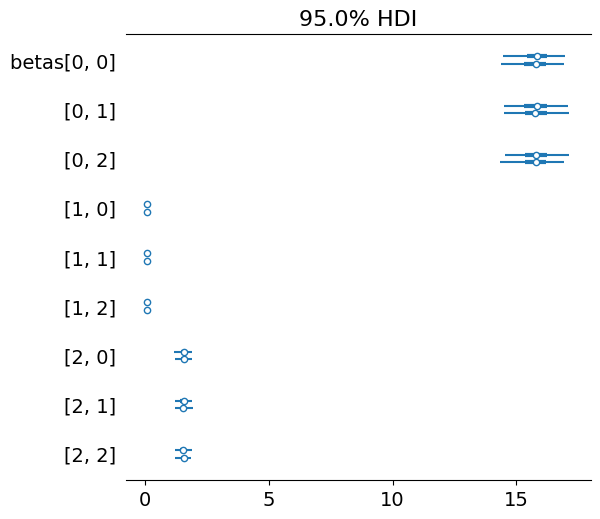

In [63]:
# Sketch credible intervals
plt.subplots_adjust(hspace=0.5)
az.plot_forest(idata, var_names=["betas"], combined=False, hdi_prob=0.95)

# Homework 5: Part II
    
## Answer the following with respect to $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ on the previous slide
    
1. Rewrite $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ in terms of $\sigma^2$ (no longer using $\Sigma$) if $\Sigma=\sigma^2I$

2. What is $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

3. What ***hyperparameters*** values (legal or illegal) would make $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

4. What ***hyperparameters*** values (legal or illegal) would make $E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

5. What is $\text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

Please refer to the hand-wrritten solution in the attached files.

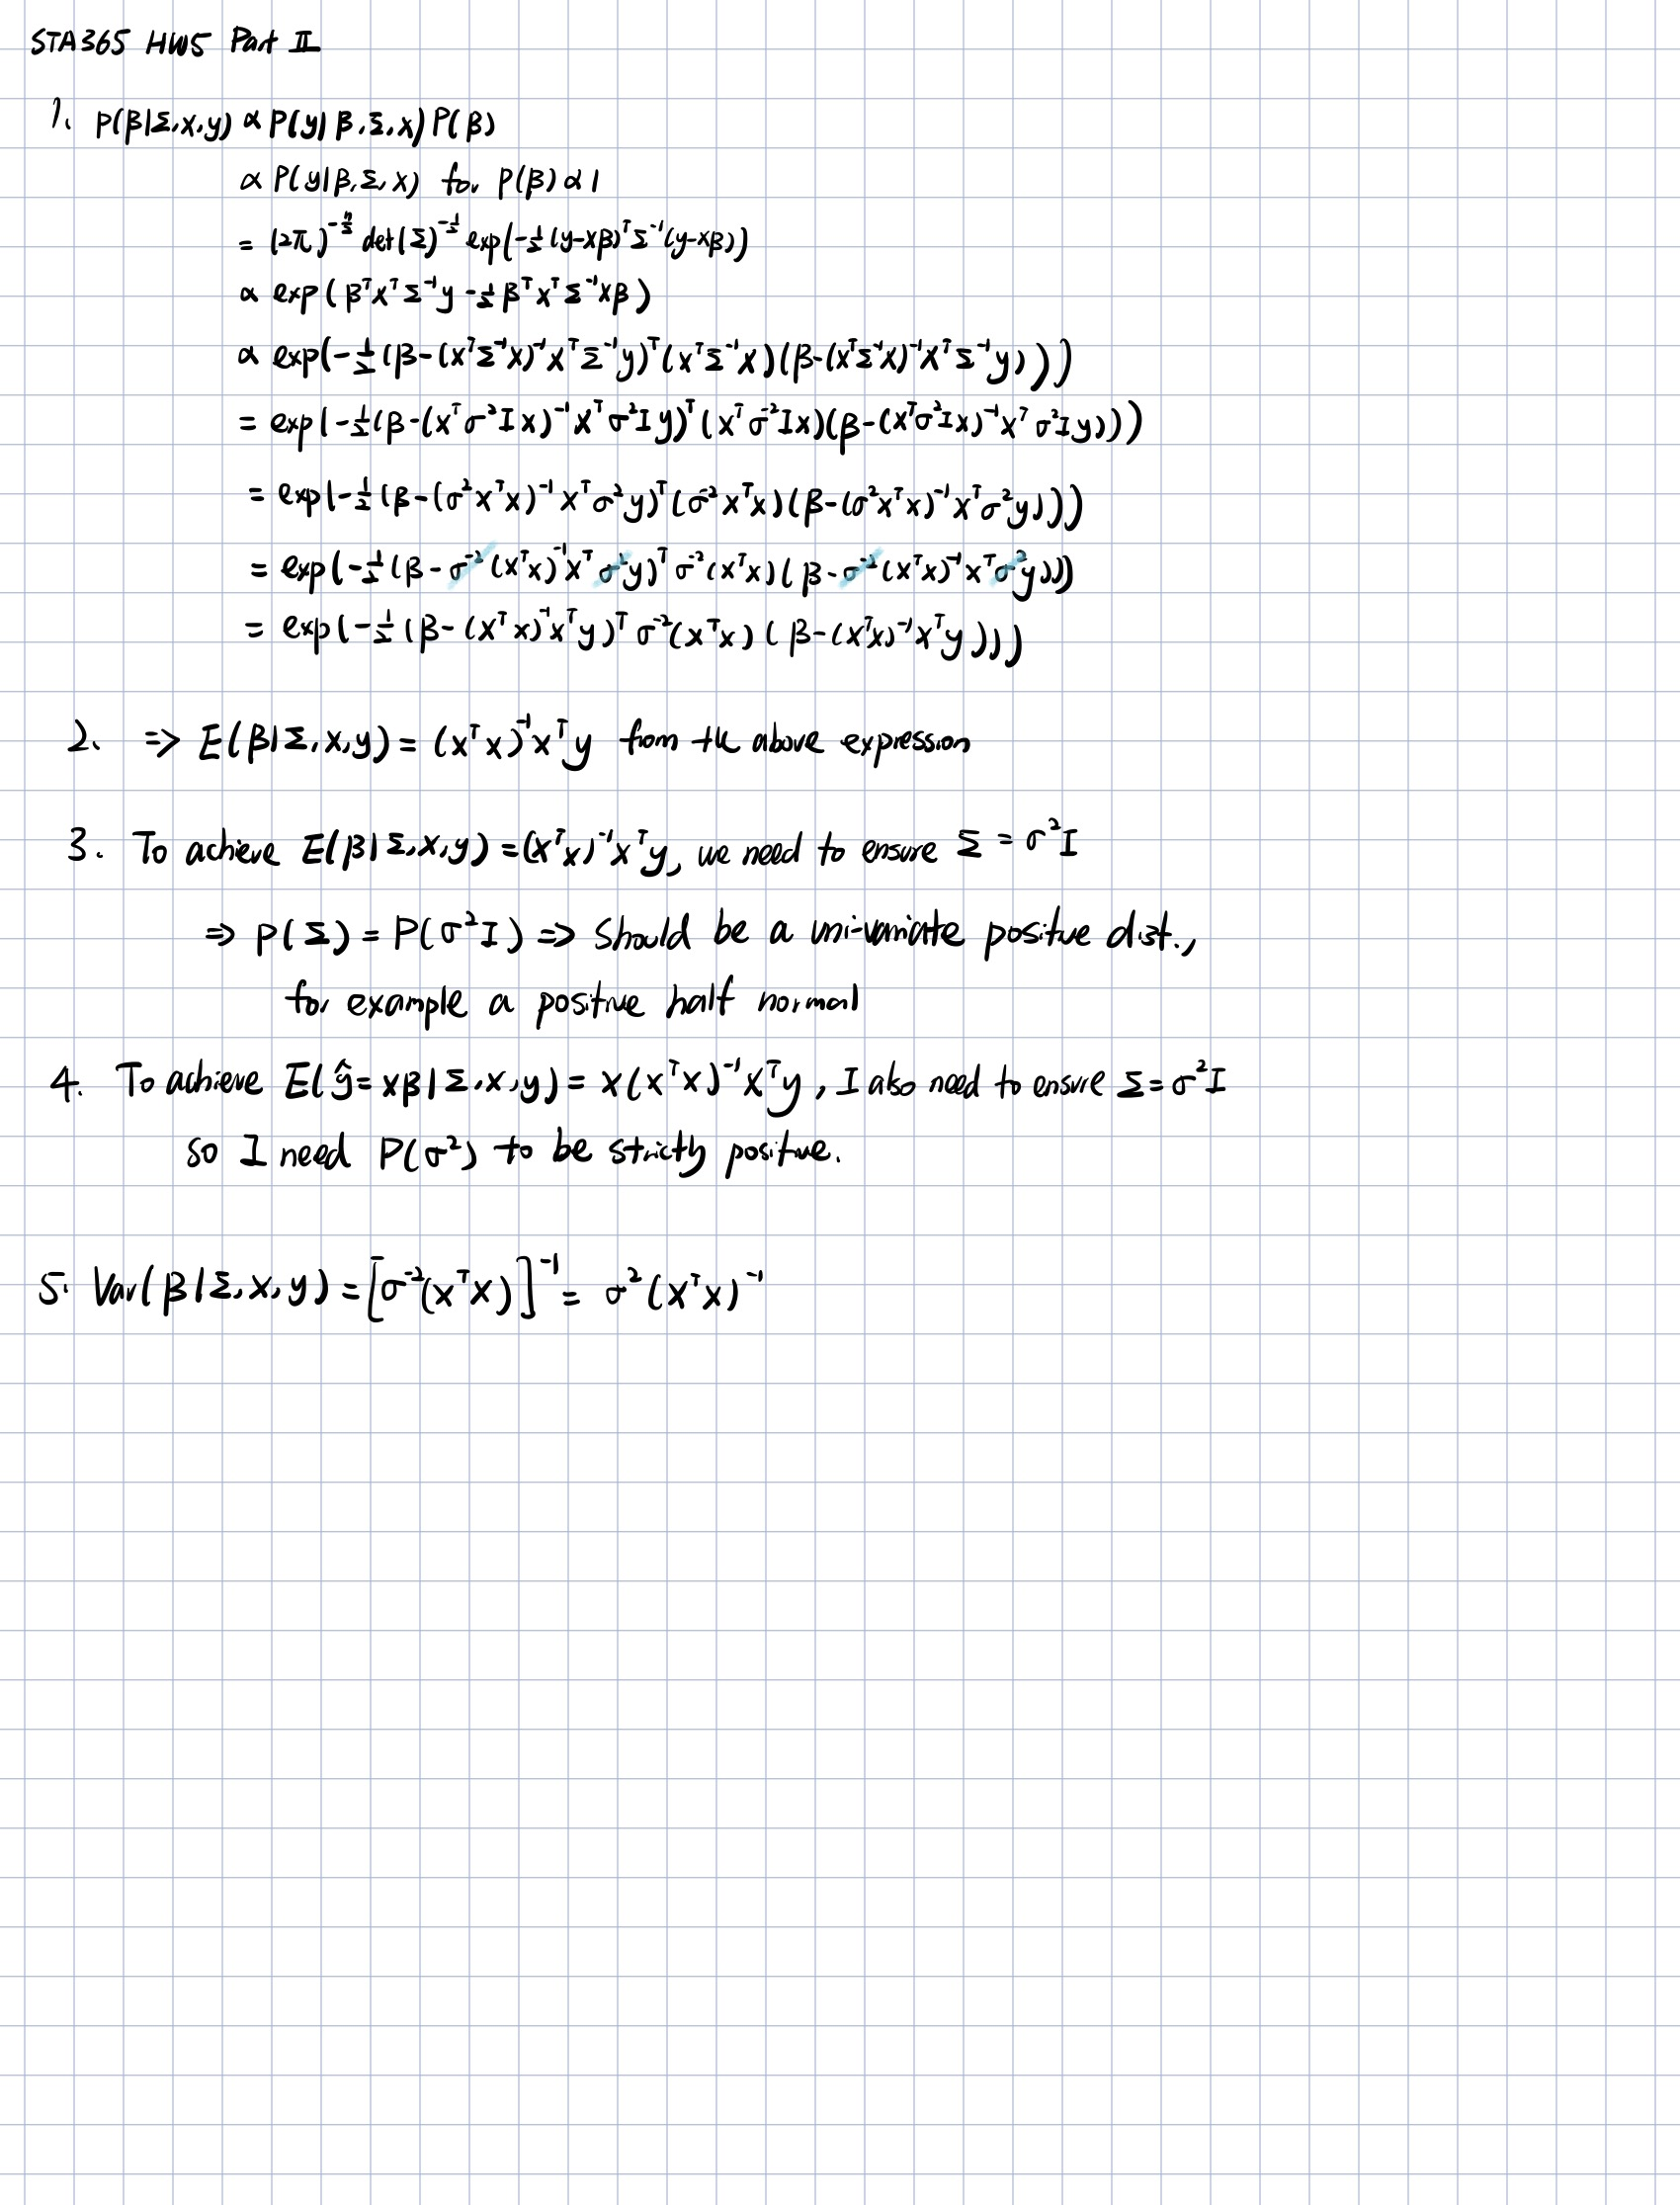

In [70]:
	# import image module
from IPython.display import Image

# get the image
image_path = '/content/drive/My Drive/Colab Notebooks/STA365 HW5 2.jpg'
Image(filename=image_path, width=1000, height=1200)

## Part 3

# Homework 5: Part III

1. Go get data from kaggle.com and perform inference for a ***Bayesian Multivariate Normal Model***

<SPAN STYLE="font-size:18.0pt">

```python
import numpy as np; from scipy import stats
p=10; Psi=np.eye(p); a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)
n=1000; y=stats.multivariate_normal(mean=np.zeros(p), cov=a_cov).rvs(size=n)
# Replace this made up data with your data set from kaggle...
    
with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    # Sigma = pm.Deterministic('Sigma', L.dot(L.T)) # Don't use a covariance matrix parameterization
    mu = pm.MvNormal('mu', mu=np.array(0), cov=np.eye(p), shape=p);
    # y = pm.MvNormal('y', mu=mu, cov=Sigma, shape=(n,1), observed=y)
    # Figure out how to parameterize this with a Cholesky factor to improve computational efficiency
with MNV_LKJ    
    idata = pm.sample()
```    
</SPAN>

2. As indicated above, don't use a covariance matrix parameterization and instead figure out how to parameterize this with a ***Cholesky factor*** to improve computational efficiency. The ***Cholesky***-based formulation allows general $O(n^3)$ $\det({\boldsymbol \Sigma})$ to be computed using a simple $O(n)$ product and general $O(n^3)$ ${\boldsymbol \Sigma}^{-1}$ to be instead evaluated with $O(n^2)$ ***backward substitution***.

2. Specify ***priors*** that work: certainly you'll likely need to change the ***prior hyperparameters*** for $\boldsymbol \mu$ (`mu`) and $\mathbf{R}$ (`packed_L`)...
    1. And you could consider adjusting the ***prior*** for $\boldsymbol \sigma$ using `sd_dist`...

3. [Optional] Assess the performance of the MCMC and note any issues

    1. Traceplots, inference (credible) intervals, effective sample sizes, energy plots, warnings and other notes... just the usual stuff they do [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)



In [114]:
p=3;
n=1000;
# Replace this made up data with your data set from kaggle...
y = df[['Age', 'PhysicalActivityLevel','BMI']].values

with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta= 2,
                                 sd_dist=pm.Exponential.dist(1.0, shape=3),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    # Don't use a covariance matrix parameterization
    # Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    # Figure out how to parameterize this with a Cholesky factor to improve
    # computational efficiency
    mu = pm.Normal('mu', mu=[0, 0, 0], sigma=[1, 1, 1], shape=3)
    y_obs = pm.MvNormal('y_obs', mu=mu, chol=L, observed = y)
with MNV_LKJ:
    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


In [116]:
# Display summary statistics
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],17.12,1.57,14.26,20.01,0.07,0.05,546.63,942.06,1.00
mu[1],5.08,0.17,4.74,5.38,0.01,0.00,1006.60,993.86,1.00
mu[2],26.81,0.35,26.15,27.47,0.02,0.01,524.29,838.91,1.01
packed_L[0],19.81,1.44,17.19,22.48,0.06,0.04,558.45,937.11,1.01
packed_L[1],-0.21,0.17,-0.52,0.09,0.01,0.00,977.81,945.01,1.00
packed_L[2],1.95,0.06,1.84,2.07,0.00,0.00,1604.72,1249.92,1.00
packed_L[3],4.10,0.33,3.50,4.70,0.01,0.01,525.86,1017.84,1.01
packed_L[4],-0.60,0.05,-0.69,-0.51,0.00,0.00,1930.56,1351.88,1.00
packed_L[5],0.98,0.03,0.92,1.03,0.00,0.00,1591.27,1249.27,1.00


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

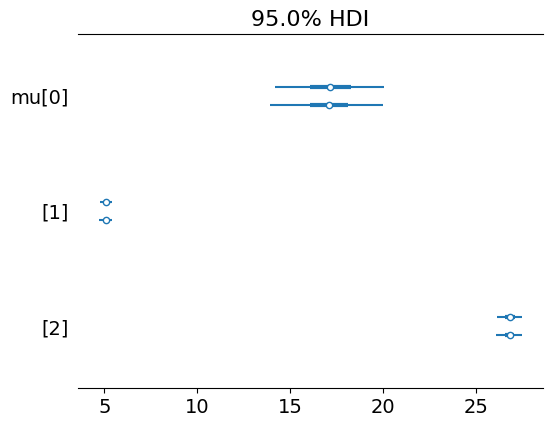

In [118]:
# Sketch credible intervals
plt.subplots_adjust(hspace=0.5)
az.plot_forest(idata, var_names=["mu"], combined=False, hdi_prob=0.95)